In [3]:
!git clone https://github.com/triton-droids/pupper-simulations.git
%cd pupper-simulations

fatal: destination path 'pupper-simulations' already exists and is not an empty directory.
/content/pupper-simulations


In [4]:
!pip install -r training_requirements.txt
%cd locomotion

/content/pupper-simulations/locomotion


In [5]:
import os

os.environ['MUJOCO_GL'] = 'egl'

In [6]:
from bittle_env import BittleEnv
from training_helpers import progress, domain_randomize

from brax import envs
import functools
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.io import model

from datetime import datetime
import sys
from etils import epath
from matplotlib import pyplot as plt

from flax.training import orbax_utils
from orbax import checkpoint as ocp

import jax
from jax import numpy as jp

import mediapy as media

import numpy as np

# **Train Policy**

/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_lf_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_lr_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_rr_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_rf_1_convex" has a coplanar face with more than 20 vertices. This may

Bittle has 9 actuators
Bittle has 16 position DOFs
Bittle has 15 velocity DOFs
Joint positions in q: indices [7:16]
Joint velocities in qd: indices [6:15]
Found lower leg body: servos_rf_1 (id=3)
Found lower leg body: servos_rr_1 (id=5)
Found lower leg body: servos_lf_1 (id=8)
Found lower leg body: servos_lr_1 (id=10)
Starting minimal test...


/usr/local/lib/python3.12/dist-packages/jax/_src/abstract_arrays.py:135: RuntimeWarning: overflow encountered in cast
  return literals.TypedNdArray(np.asarray(x, dtype), weak_type=False)



EVALUATION AT STEP 0
Episode Reward:     -3.4397 ± 2.7407
Time since last:    361.31s

All available metrics:
  eval/epoch_eval_time          : 322.501361
  eval/sps                      : 39.689755
  eval/walltime                 : 322.501361



<Figure size 640x480 with 0 Axes>

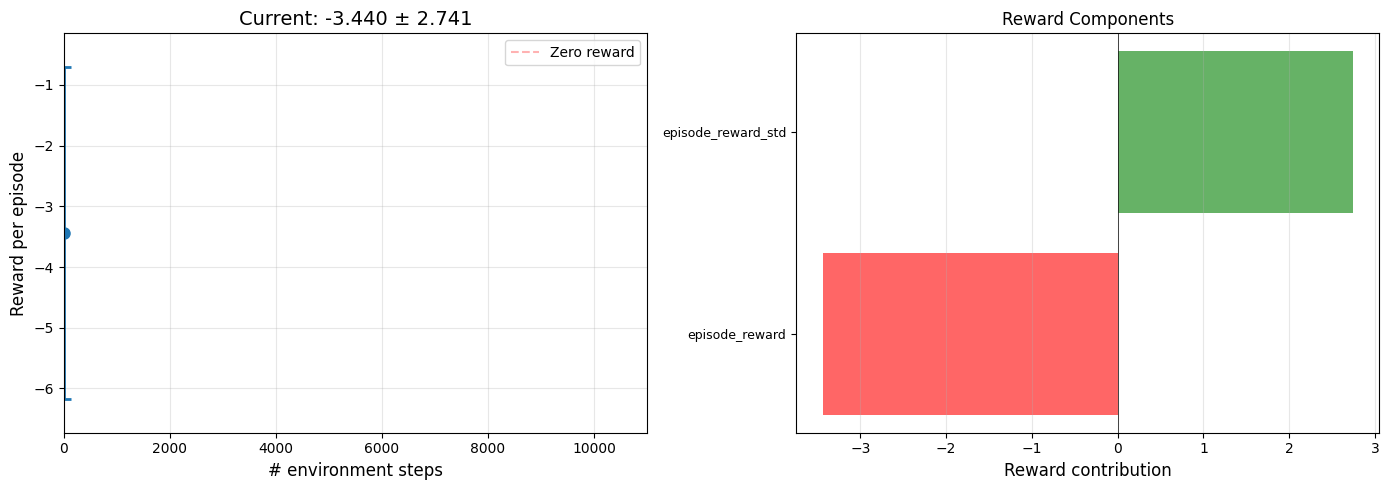

/usr/local/lib/python3.12/dist-packages/jax/_src/abstract_arrays.py:135: RuntimeWarning: overflow encountered in cast
  return literals.TypedNdArray(np.asarray(x, dtype), weak_type=False)



EVALUATION AT STEP 10000
Episode Reward:     -3.3524 ± 2.4551
Time since last:    597.98s

All available metrics:
  eval/epoch_eval_time          : 324.693669
  eval/sps                      : 39.421773
  eval/walltime                 : 647.195030
  training/sps                  : 36.777178
  training/walltime             : 271.907761

Reward change: +0.0872
Best so far:   -3.3524
Worst so far:  -3.4397



<Figure size 640x480 with 0 Axes>

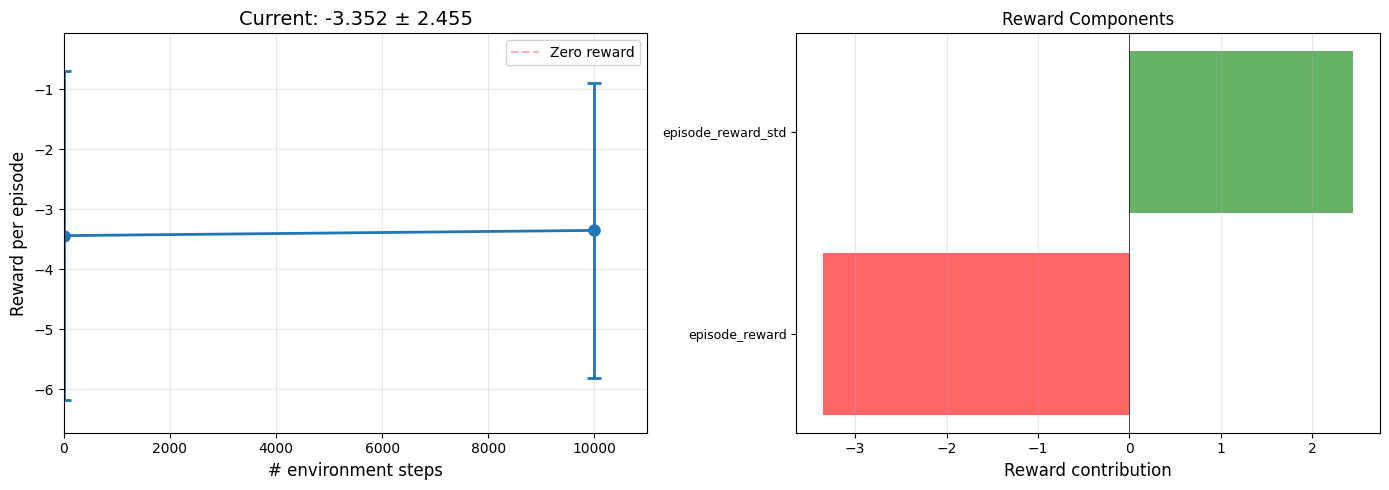

Test completed!


In [7]:
envs.register_environment('bittle', BittleEnv)

env_name = 'bittle'
xml_path = 'bittle_adapted_scene.xml'
env = envs.get_environment(env_name, xml_path = xml_path)

ckpt_path = epath.Path('/tmp/quadrupred_joystick/ckpts')
ckpt_path.mkdir(parents=True, exist_ok=True)

def policy_params_fn(current_step, make_policy, params):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f'{current_step}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)


# Minimal training config with COMPATIBLE parameters
train_fn = functools.partial(
    ppo.train,
    num_timesteps=10_000,      # Very short
    num_evals=2,               # Just 2 evaluations
    episode_length=100,        # Short episodes
    num_envs=4,                # Minimal envs
    batch_size=4,              # batch_size * num_minibatches must be divisible by num_envs
    unroll_length=5,
    num_minibatches=2,         # 4 * 2 = 8, and 8 % 4 = 0 ✅
    num_updates_per_batch=1,
)

print("Starting minimal test...")

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 40, 0
'''
Callback function to plot training progress.
'''
def progress_x(num_steps, metrics):
    """Enhanced progress callback with detailed metrics and better visualization."""
    print("\n" + "="*60)
    print(f"EVALUATION AT STEP {num_steps}")
    print("="*60)

    # Collect timing info
    times.append(datetime.now())
    time_delta = (times[-1] - times[-2]).total_seconds() if len(times) > 1 else 0

    # Extract key metrics
    episode_reward = metrics['eval/episode_reward']
    episode_reward_std = metrics['eval/episode_reward_std']

    # Print detailed metrics
    print(f"Episode Reward:     {episode_reward:.4f} ± {episode_reward_std:.4f}")
    print(f"Time since last:    {time_delta:.2f}s")

    # Print ALL available metrics for debugging
    print("\nAll available metrics:")
    for key, value in sorted(metrics.items()):
        if isinstance(value, (int, float, np.ndarray)):
            if isinstance(value, np.ndarray):
                value = float(value)
            print(f"  {key:30s}: {value:.6f}")

    # Store data
    x_data.append(num_steps)
    y_data.append(float(episode_reward))
    ydataerr.append(float(episode_reward_std))

    # Calculate statistics
    if len(y_data) > 1:
        improvement = y_data[-1] - y_data[-2]
        print(f"\nReward change: {improvement:+.4f}")
        print(f"Best so far:   {max(y_data):.4f}")
        print(f"Worst so far:  {min(y_data):.4f}")

    print("="*60 + "\n")

    # Improved plotting
    plt.clf()  # Clear the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Left plot: Reward over time
    ax1.errorbar(x_data, y_data, yerr=ydataerr,
                 marker='o', capsize=5, capthick=2,
                 linewidth=2, markersize=8)
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='Zero reward')
    ax1.set_xlim([0, train_fn.keywords['num_timesteps'] * 1.1])

    # Auto-adjust y-limits based on data
    if y_data:
        y_min = min(y_data) - max(ydataerr) * 1.2
        y_max = max(y_data) + max(ydataerr) * 1.2
        ax1.set_ylim([y_min, y_max])

    ax1.set_xlabel('# environment steps', fontsize=12)
    ax1.set_ylabel('Reward per episode', fontsize=12)
    ax1.set_title(f'Current: {y_data[-1]:.3f} ± {ydataerr[-1]:.3f}', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Right plot: Individual reward components if available
    reward_components = {k: v for k, v in metrics.items()
                        if k.startswith('eval/episode_reward/') or
                           (k.startswith('eval/') and 'reward' in k.lower())}

    if reward_components:
        names = [k.replace('eval/episode_reward/', '').replace('eval/', '')
                for k in reward_components.keys()]
        values = [float(v) for v in reward_components.values()]

        colors = ['green' if v > 0 else 'red' for v in values]
        ax2.barh(range(len(names)), values, color=colors, alpha=0.6)
        ax2.set_yticks(range(len(names)))
        ax2.set_yticklabels(names, fontsize=9)
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Reward contribution', fontsize=12)
        ax2.set_title('Reward Components', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='x')
    else:
        ax2.text(0.5, 0.5, 'No component\nbreakdown available',
                ha='center', va='center', fontsize=12)
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

make_inference_fn, params, _ = train_fn(
    environment=env,
    progress_fn=progress_x,
)
print("Test completed!")


'''
Real Training Params

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train, num_timesteps=100_000, num_evals=1_000,
      reward_scaling=1, episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2, num_envs=256, batch_size=256,
      network_factory=make_networks_factory,
      randomization_fn=domain_randomize,
      policy_params_fn=policy_params_fn,
      seed=0)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name, xml_path = xml_path)
eval_env = envs.get_environment(env_name, xml_path = xml_path)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')
'''
# Save and reload params.
model_path = '/tmp/mjx_brax_quadruped_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

# **Visualize Policy**

In [8]:
eval_env = envs.get_environment(env_name, xml_path = xml_path)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_lf_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_lr_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_rr_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(


Bittle has 9 actuators
Bittle has 16 position DOFs
Bittle has 15 velocity DOFs
Joint positions in q: indices [7:16]
Joint velocities in qd: indices [6:15]
Found lower leg body: servos_rf_1 (id=3)
Found lower leg body: servos_rr_1 (id=5)
Found lower leg body: servos_lf_1 (id=8)
Found lower leg body: servos_lr_1 (id=10)


/usr/local/lib/python3.12/dist-packages/mujoco/mjx/_src/mesh.py:141: UserWarning: Mesh "shank_rf_1_convex" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [13]:

# @markdown Commands **only used for Barkour Env**:
x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
ang_vel = -0.5  #@param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info['command'] = the_command
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  if i % 50 == 0:
    print(f"Step: {i}")
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(
    eval_env.render(rollout[::render_every], camera='track'),
    fps=1.0 / eval_env.dt / render_every)

Step: 0
Step: 50
Step: 100
Step: 150
Step: 200
Step: 250
Step: 300
Step: 350
Step: 400
Step: 450
